## Setup

In [2]:
nx = 50
ny = 50

n = nx * ny
p = 30
s = 30

In [3]:
xs = np.linspace(0, 25, nx)
ys = np.linspace(0, 25, ny)
c_x, c_y = np.meshgrid(xs, ys)
c_x = c_x.flatten()
c_y = c_y.flatten()
coord = np.stack([c_x, c_y]).T

In [4]:
Sigma = gen_cov_mat(c_x, c_y, RBF(length_scale=5.))
Chol = np.linalg.cholesky(Sigma + .1*np.eye(n))

## Generate Gaussian X, Y

In [5]:
(Chol[0,0] * Chol[:,0])[:10]

array([1.1       , 0.99480736, 0.97939068, 0.9542253 , 0.92007635,
       0.87796012, 0.82909386, 0.77483743, 0.71663079, 0.65593125])

In [6]:
X = gen_rbf_X(c_x, c_y, p)
# X = gen_matern_X(c_x, c_y, p, length_scale=1, nu=1)
# X = np.random.randn(n,p)

beta = np.zeros(p)
idx = np.random.choice(p,size=s)
beta[idx] = np.random.uniform(-1,1,size=s)

In [7]:
Y = X @ beta + Chol @ np.random.randn(n)

In [8]:
tr_idx = np.random.choice(n, size=int(.2*n), replace=False)
tr_bool = np.zeros(n, dtype=bool)
tr_bool[tr_idx] = True

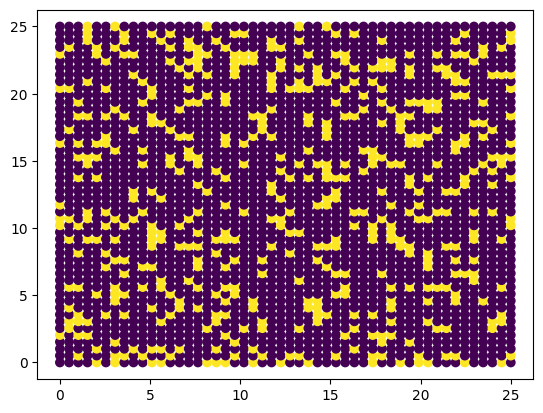

In [9]:
plt.scatter(c_x, c_y, c=tr_bool, label=tr_bool)


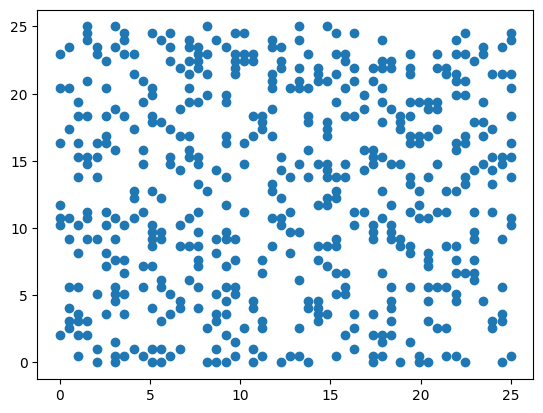

In [10]:
plt.scatter(c_x[tr_bool], c_y[tr_bool])


In [11]:
def kFoldCV(X, y):
    return cross_validate(
        LinearRegression(), 
        X, 
        y, 
        cv=KFold(n_splits=10, shuffle=True), 
        scoring='neg_mean_squared_error'
    )

def ErrXY(X, y, tr_idx):
    m = LinearRegression()
    m.fit(X[tr_idx], y[tr_idx])
    return np.mean((y[~tr_idx] - m.predict(X[~tr_idx]))**2)

# def ErrX(X, beta, Chol, tr_idx, niter=100):
#     errs = np.zeros(niter)
#     for i in np.arange(niter):
#         Y = X@beta + Chol @ np.random.randn(n)
#         errs[i] = ErrXY(X, Y, tr_idx)
#     return np.mean(errs)

def AvgErr(c_x, c_y, p, beta, Chol, niter=100): 
    n = len(c_x)
    errs = np.zeros(niter)
    for i in np.arange(niter):    
        tr_idx = np.random.choice(n, size=int(.2*n), replace=False)
        tr_bool = np.zeros(n, dtype=bool)
        tr_bool[tr_idx] = True
        
        X = gen_rbf_X(c_x, c_y, p)
        Y = X@beta + Chol @ np.random.randn(n)
        errs[i] = ErrXY(X, Y, tr_bool)
    return np.mean(errs)

In [52]:
kfcverr = -kFoldCV(X[tr_bool], Y[tr_bool])['test_score'].mean()

In [53]:
avgerr = AvgErr(c_x, c_y, p, beta, Chol)

KeyboardInterrupt: 

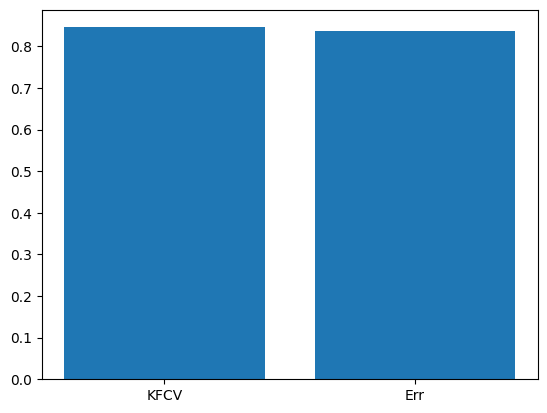

In [ ]:
fig, ax = plt.subplots()
ax.bar(x=np.arange(2),height=[kfcverr, avgerr])
ax.set_xticks(np.arange(2), labels=['KFCV', 'Err'])

In [ ]:
[kfcverr, avgerr]


[0.8459666431245505, 0.8374072139872015]

In [11]:
def sim(c_x, c_y, n, p, beta, Chol, nsims=100):
    res = np.zeros((2,nsims))
    
    # for i in np.arange(nsims):
    #     if i % 10 == 0: 
    #         print(i)
    for i in tqdm(range(nsims)):
            
        tr_idx = np.random.choice(n, size=int(.2*n), replace=False)
        tr_bool = np.zeros(n, dtype=bool)
        tr_bool[tr_idx] = True

        X = gen_rbf_X(c_x, c_y, p)
        Y = X@beta + Chol @ np.random.randn(n)
        
        res[0,i] = -kFoldCV(X[tr_bool], Y[tr_bool])['test_score'].mean()

        res[1,i] = AvgErr(c_x, c_y, p, beta, Chol)
        
    return res

In [ ]:
res = sim(c_x, c_y, n, p, beta, Chol, 100)

  0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

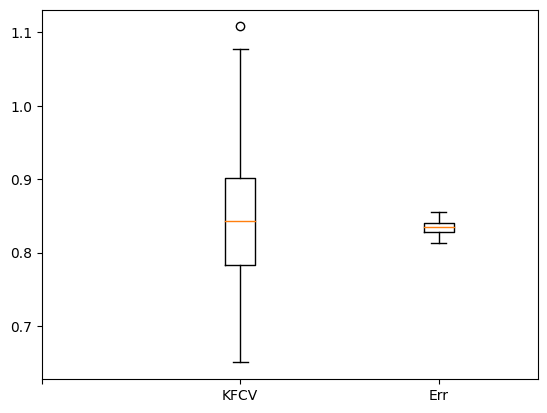

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(res.T)
ax.set_xticks(np.arange(3), labels=['', 'KFCV', 'Err'])

In [ ]:
res.mean(1)

array([0.84363954, 0.83445804])

In [ ]:
res.mean(1) / res.mean(1)[1]

array([1.01100295, 1.        ])